# Análise e Predição de Séries Temporais - Dataset de Futebol Internacional

## Dataset
**International Football Results from 1872 to 2025**

Link do Kaggle: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017

Este notebook analisa a série temporal de gols marcados em partidas internacionais de futebol e desenvolve modelos de predição usando:
1. **Prophet** (Facebook)
2. **Sktime** (AutoARIMA)
3. **LSTM** (Long Short-Term Memory Networks)

---

## 1. Instalação e Importação de Bibliotecas

In [3]:
# Instalação das bibliotecas necessárias
!pip install prophet sktime pmdarima tensorflow scikit-learn pandas numpy matplotlib seaborn opendatasets -q

In [4]:
# Importações
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

# Sktime
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.base import ForecastingHorizon

# LSTM
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Configurações
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

print("✓ Bibliotecas importadas com sucesso!")
print(f"TensorFlow versão: {tf.__version__}")

✓ Bibliotecas importadas com sucesso!
TensorFlow versão: 2.19.0


## 2. Download e Carregamento dos Dados

In [5]:
# Método alternativo: Download direto do dataset
# Se você tiver credenciais do Kaggle, descomente e use:
# import opendatasets as od
# od.download("https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017")

# Para este exemplo, vou usar o CSV diretamente
# Faça o download manual do dataset e coloque na pasta do notebook
# Link: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017

print("⚠️ INSTRUÇÕES PARA DOWNLOAD:")
print("1. Acesse: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017")
print("2. Faça o download do arquivo 'results.csv'")
print("3. Coloque o arquivo na mesma pasta deste notebook")
print("\nOu execute o código abaixo se tiver API key do Kaggle configurada:")

⚠️ INSTRUÇÕES PARA DOWNLOAD:
1. Acesse: https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017
2. Faça o download do arquivo 'results.csv'
3. Coloque o arquivo na mesma pasta deste notebook

Ou execute o código abaixo se tiver API key do Kaggle configurada:


In [7]:
# Carregar o dataset
try:
    df = pd.read_csv('results.csv')
    print("✓ Dataset carregado com sucesso!")
except FileNotFoundError:
    print("❌ Arquivo 'results.csv' não encontrado.")
    print("Por favor, baixe o dataset do Kaggle conforme instruções acima.")
    raise

# Visualizar primeiras linhas
print(f"\nShape do dataset: {df.shape}")
df.head(10)

✓ Dataset carregado com sucesso!

Shape do dataset: (48532, 9)


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False
5,1876-03-25,Scotland,Wales,4,0,Friendly,Glasgow,Scotland,False
6,1877-03-03,England,Scotland,1,3,Friendly,London,England,False
7,1877-03-05,Wales,Scotland,0,2,Friendly,Wrexham,Wales,False
8,1878-03-02,Scotland,England,7,2,Friendly,Glasgow,Scotland,False
9,1878-03-23,Scotland,Wales,9,0,Friendly,Glasgow,Scotland,False


## 3. Análise Exploratória e Preparação dos Dados

In [10]:
# Informações gerais
print("Informações do Dataset:")
print(df.info())
print("\nEstatísticas Descritivas:")
print(df.describe())

Informações do Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48532 entries, 0 to 48531
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   date         48532 non-null  datetime64[ns]
 1   home_team    48532 non-null  object        
 2   away_team    48532 non-null  object        
 3   home_score   48532 non-null  int64         
 4   away_score   48532 non-null  int64         
 5   tournament   48532 non-null  object        
 6   city         48532 non-null  object        
 7   country      48532 non-null  object        
 8   neutral      48532 non-null  bool          
 9   total_goals  48532 non-null  int64         
dtypes: bool(1), datetime64[ns](1), int64(3), object(5)
memory usage: 3.4+ MB
None

Estatísticas Descritivas:
                                date    home_score    away_score   total_goals
count                          48532  48532.000000  48532.000000  48532.000000
mean   1993

In [11]:
# Converter data para datetime
df['date'] = pd.to_datetime(df['date'])

# Criar coluna de total de gols por partida
df['total_goals'] = df['home_score'] + df['away_score']

# Agregar dados mensalmente (série temporal)
df_monthly = df.groupby(pd.Grouper(key='date', freq='M')).agg({
    'total_goals': 'sum',
    'home_score': 'count'  # número de partidas
}).reset_index()

df_monthly.columns = ['date', 'total_goals', 'num_matches']

# Média de gols por partida (métrica mais estável)
df_monthly['avg_goals_per_match'] = df_monthly['total_goals'] / df_monthly['num_matches']

# Filtrar para ter dados suficientes (últimos 20 anos)
df_monthly = df_monthly[df_monthly['date'] >= '2005-01-01']
df_monthly = df_monthly.dropna()

print(f"\nSérie temporal preparada: {len(df_monthly)} observações mensais")
print(f"Período: {df_monthly['date'].min()} a {df_monthly['date'].max()}")
df_monthly.head()


Série temporal preparada: 239 observações mensais
Período: 2005-01-31 00:00:00 a 2025-09-30 00:00:00


,date,total_goals,num_matches,avg_goals_per_match
1586,2005-01-31,79,30,2.633333
1587,2005-02-28,202,81,2.493827
1588,2005-03-31,318,106,3.000000
1589,2005-04-30,16,7,2.285714
1590,2005-05-31,81,27,3.000000


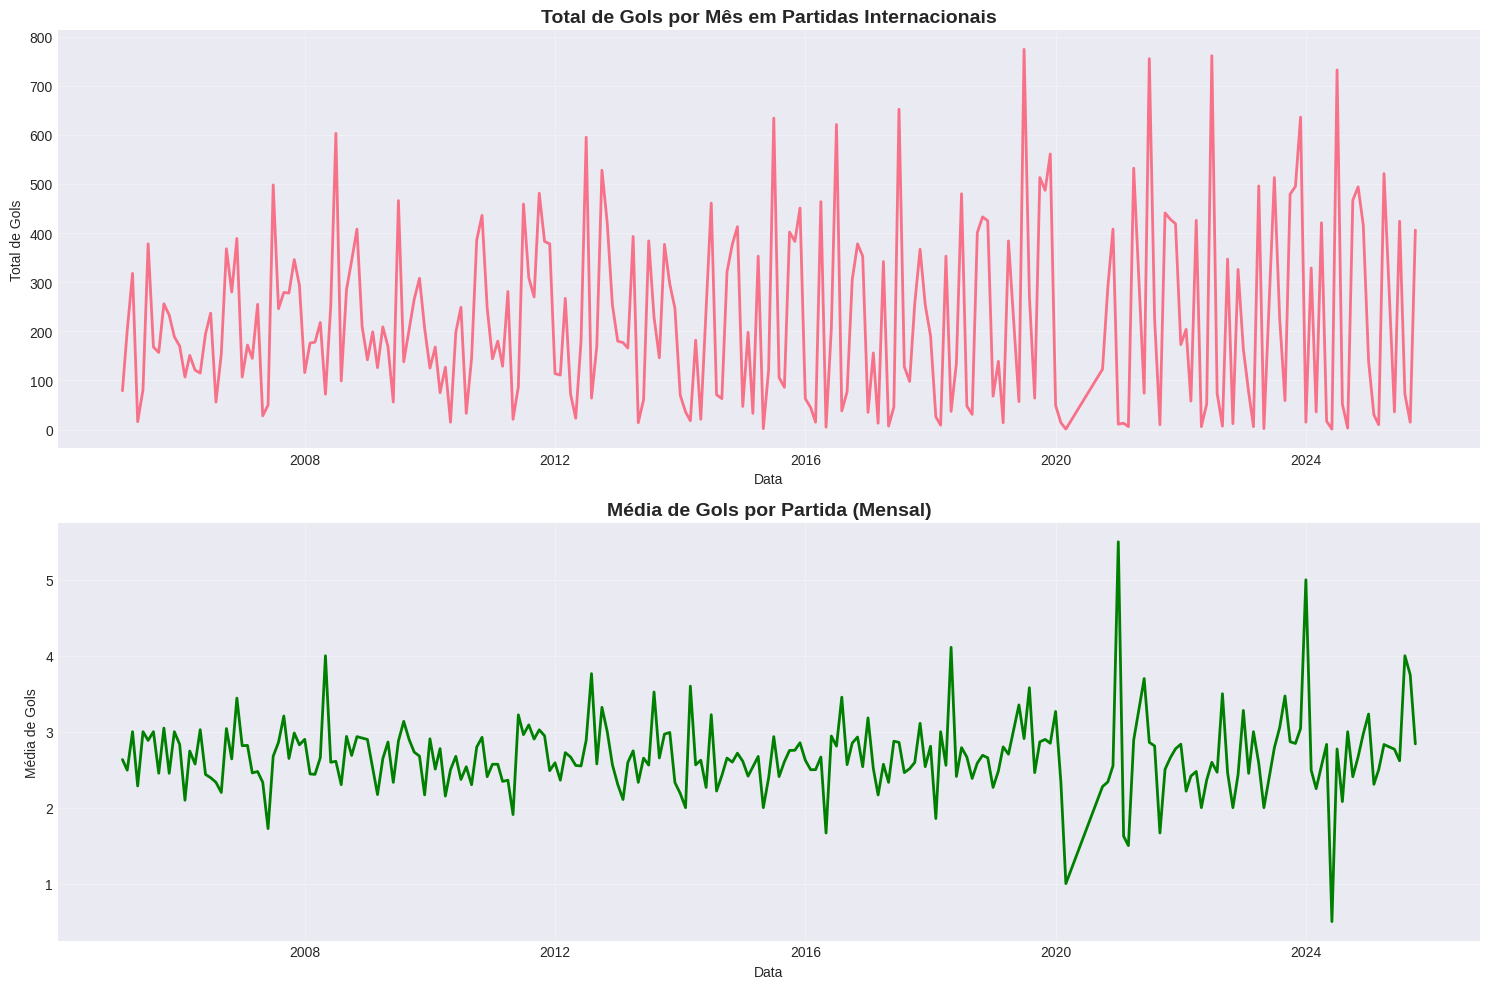


Média geral de gols por partida: 2.68
Desvio padrão: 0.50


In [12]:
# Visualização da série temporal
fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# Total de gols por mês
axes[0].plot(df_monthly['date'], df_monthly['total_goals'], linewidth=2)
axes[0].set_title('Total de Gols por Mês em Partidas Internacionais', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Data')
axes[0].set_ylabel('Total de Gols')
axes[0].grid(True, alpha=0.3)

# Média de gols por partida
axes[1].plot(df_monthly['date'], df_monthly['avg_goals_per_match'], color='green', linewidth=2)
axes[1].set_title('Média de Gols por Partida (Mensal)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Data')
axes[1].set_ylabel('Média de Gols')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nMédia geral de gols por partida: {df_monthly['avg_goals_per_match'].mean():.2f}")
print(f"Desvio padrão: {df_monthly['avg_goals_per_match'].std():.2f}")

## 4. Divisão dos Dados (Train/Test)

Vamos usar 80% para treino e 20% para teste.

In [13]:
# Usar média de gols por partida como variável alvo (mais estável)
ts_data = df_monthly[['date', 'avg_goals_per_match']].copy()
ts_data = ts_data.sort_values('date').reset_index(drop=True)

# Divisão 80/20
train_size = int(len(ts_data) * 0.8)
train_data = ts_data[:train_size]
test_data = ts_data[train_size:]

print(f"Tamanho do conjunto de treino: {len(train_data)}")
print(f"Tamanho do conjunto de teste: {len(test_data)}")
print(f"\nPeríodo de treino: {train_data['date'].min()} a {train_data['date'].max()}")
print(f"Período de teste: {test_data['date'].min()} a {test_data['date'].max()}")

Tamanho do conjunto de treino: 191
Tamanho do conjunto de teste: 48

Período de treino: 2005-01-31 00:00:00 a 2021-07-31 00:00:00
Período de teste: 2021-08-31 00:00:00 a 2025-09-30 00:00:00


## 5. Modelo 1: Prophet (Facebook)

Prophet é uma biblioteca desenvolvida pelo Facebook especialmente projetada para séries temporais com sazonalidade.

In [14]:
# Preparar dados para Prophet (necessita colunas 'ds' e 'y')
prophet_train = train_data.rename(columns={'date': 'ds', 'avg_goals_per_match': 'y'})
prophet_test = test_data.rename(columns={'date': 'ds', 'avg_goals_per_match': 'y'})

# Criar e treinar modelo Prophet
print("Treinando modelo Prophet...")
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode='multiplicative',
    changepoint_prior_scale=0.05
)

prophet_model.fit(prophet_train)
print("✓ Modelo Prophet treinado!")

# Fazer predições
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')
prophet_forecast = prophet_model.predict(future)

# Extrair predições para o período de teste
prophet_predictions = prophet_forecast.iloc[train_size:][['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
prophet_predictions = prophet_predictions.reset_index(drop=True)

print(f"\nPrimeiras predições do Prophet:")
print(prophet_predictions.head())

Treinando modelo Prophet...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpcs9a9xdy/nd12kwua.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpcs9a9xdy/rdzqitqd.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=42558', 'data', 'file=/tmp/tmpcs9a9xdy/nd12kwua.json', 'init=/tmp/tmpcs9a9xdy/rdzqitqd.json', 'output', 'file=/tmp/tmpcs9a9xdy/prophet_model_j__cnr7/prophet_model-20251007225901.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:59:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:59:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


✓ Modelo Prophet treinado!

Primeiras predições do Prophet:
          ds      yhat  yhat_lower  yhat_upper
0 2021-08-31  2.614554    2.105265    3.114047
1 2021-09-30  2.820471    2.298407    3.314984
2 2021-10-31  2.824387    2.285011    3.364744
3 2021-11-30  2.690937    2.187101    3.203248
4 2021-12-31  2.995126    2.449736    3.516450


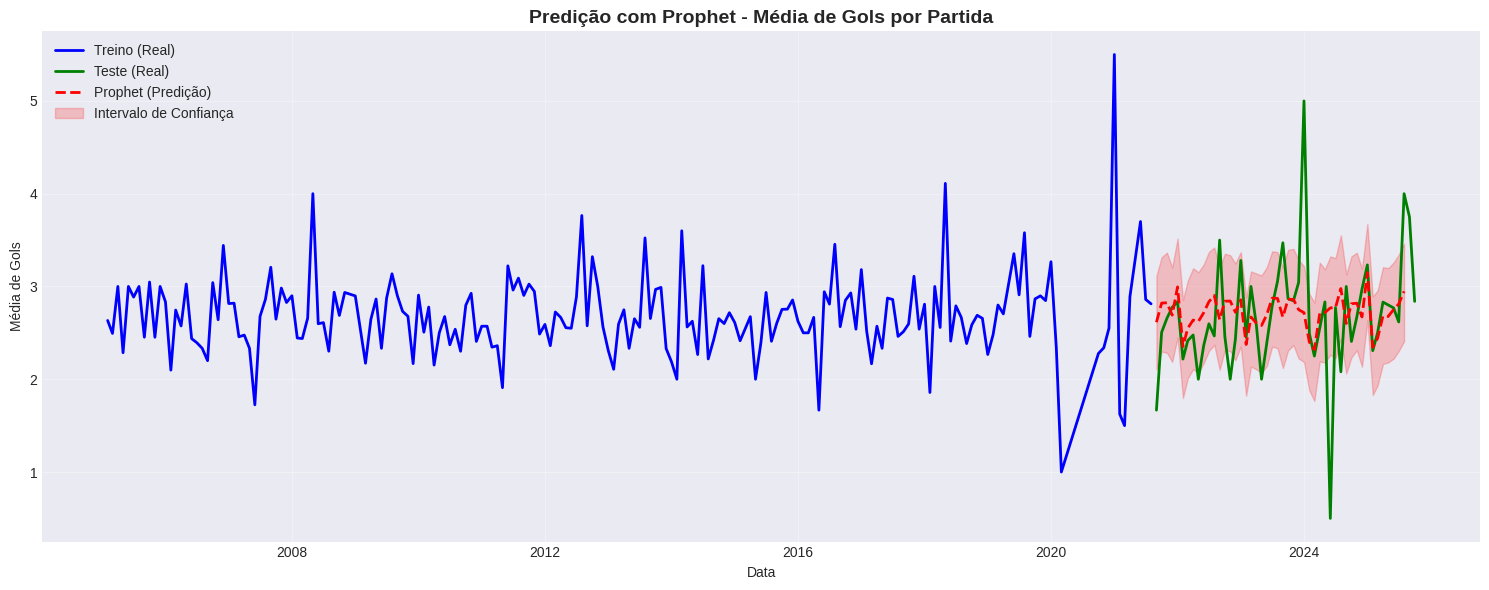

In [15]:
# Visualizar resultados do Prophet
fig, ax = plt.subplots(figsize=(15, 6))

# Dados reais
ax.plot(train_data['date'], train_data['avg_goals_per_match'],
        label='Treino (Real)', color='blue', linewidth=2)
ax.plot(test_data['date'], test_data['avg_goals_per_match'],
        label='Teste (Real)', color='green', linewidth=2)

# Predições Prophet
ax.plot(prophet_predictions['ds'], prophet_predictions['yhat'],
        label='Prophet (Predição)', color='red', linewidth=2, linestyle='--')
ax.fill_between(prophet_predictions['ds'],
                prophet_predictions['yhat_lower'],
                prophet_predictions['yhat_upper'],
                alpha=0.2, color='red', label='Intervalo de Confiança')

ax.set_title('Predição com Prophet - Média de Gols por Partida', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Média de Gols')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 6. Modelo 2: Sktime (AutoARIMA)

Sktime é uma biblioteca especializada em séries temporais. Vamos usar AutoARIMA para encontrar os melhores parâmetros automaticamente.

In [16]:
# Preparar dados para Sktime
y_train = train_data.set_index('date')['avg_goals_per_match']
y_test = test_data.set_index('date')['avg_goals_per_match']

# Criar e treinar modelo AutoARIMA
print("Treinando modelo AutoARIMA (Sktime)...")
print("Isso pode levar alguns minutos para encontrar os melhores parâmetros...")

sktime_model = AutoARIMA(
    start_p=1, start_q=1,
    max_p=5, max_q=5,
    seasonal=True,
    m=12,  # sazonalidade mensal
    stepwise=True,
    suppress_warnings=True,
    error_action='ignore'
)

sktime_model.fit(y_train)
print("✓ Modelo AutoARIMA treinado!")
print(f"\nModelo selecionado: {sktime_model.get_fitted_params()['order']}")

# Fazer predições
fh = ForecastingHorizon(y_test.index, is_relative=False)
sktime_predictions = sktime_model.predict(fh)

print(f"\nPrimeiras predições do Sktime:")
print(sktime_predictions.head())

Treinando modelo AutoARIMA (Sktime)...
Isso pode levar alguns minutos para encontrar os melhores parâmetros...


TypeError: AutoARIMA.__init__() got an unexpected keyword argument 'm'

NameError: name 'sktime_predictions' is not defined

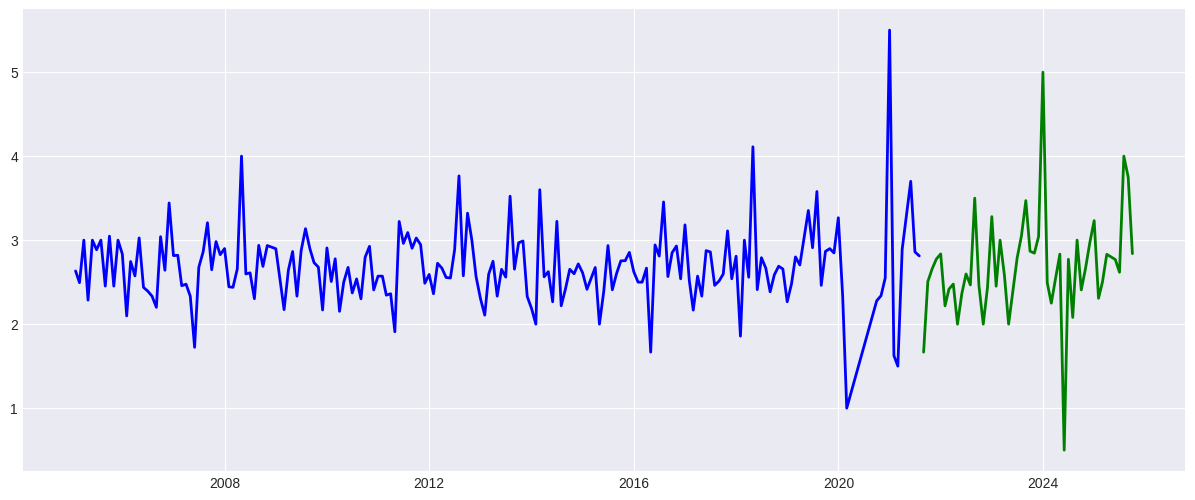

In [17]:
# Visualizar resultados do Sktime
fig, ax = plt.subplots(figsize=(15, 6))

# Dados reais
ax.plot(y_train.index, y_train.values,
        label='Treino (Real)', color='blue', linewidth=2)
ax.plot(y_test.index, y_test.values,
        label='Teste (Real)', color='green', linewidth=2)

# Predições Sktime
ax.plot(sktime_predictions.index, sktime_predictions.values,
        label='Sktime AutoARIMA (Predição)', color='orange', linewidth=2, linestyle='--')

ax.set_title('Predição com Sktime AutoARIMA - Média de Gols por Partida', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Média de Gols')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 7. Modelo 3: LSTM (Long Short-Term Memory)

LSTM é uma rede neural recorrente especialmente eficaz para séries temporais.

In [18]:
# Preparar dados para LSTM
def create_sequences(data, seq_length):
    """Cria sequências para LSTM"""
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# Normalizar dados (LSTM funciona melhor com dados normalizados)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ts_data[['avg_goals_per_match']])

# Parâmetros
seq_length = 12  # usar últimos 12 meses para prever o próximo

# Criar sequências
X, y = create_sequences(scaled_data.flatten(), seq_length)

# Dividir em treino e teste
X_train = X[:train_size-seq_length]
y_train_lstm = y[:train_size-seq_length]
X_test = X[train_size-seq_length:]
y_test_lstm = y[train_size-seq_length:]

# Reshape para LSTM [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

print(f"Shape X_train: {X_train.shape}")
print(f"Shape y_train: {y_train_lstm.shape}")
print(f"Shape X_test: {X_test.shape}")
print(f"Shape y_test: {y_test_lstm.shape}")

Shape X_train: (179, 12, 1)
Shape y_train: (179,)
Shape X_test: (48, 12, 1)
Shape y_test: (48,)


In [19]:
# Construir modelo LSTM
print("Construindo modelo LSTM...")

np.random.seed(42)
tf.random.set_seed(42)

lstm_model = Sequential([
    LSTM(50, activation='relu', return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print(lstm_model.summary())

Construindo modelo LSTM...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 12, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 12, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

None


In [20]:
# Treinar modelo LSTM
print("\nTreinando modelo LSTM...")

early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train, y_train_lstm,
    epochs=100,
    batch_size=16,
    validation_split=0.1,
    callbacks=[early_stopping],
    verbose=0
)

print("✓ Modelo LSTM treinado!")


Treinando modelo LSTM...
✓ Modelo LSTM treinado!


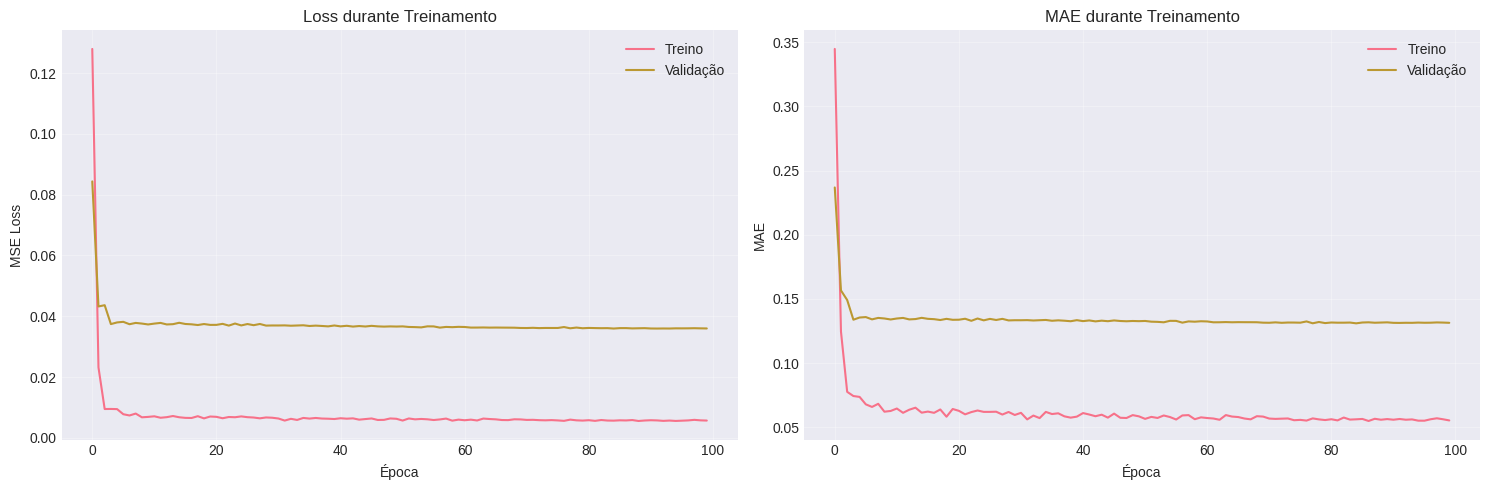

In [21]:
# Visualizar histórico de treinamento
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(history.history['loss'], label='Treino')
axes[0].plot(history.history['val_loss'], label='Validação')
axes[0].set_title('Loss durante Treinamento')
axes[0].set_xlabel('Época')
axes[0].set_ylabel('MSE Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history.history['mae'], label='Treino')
axes[1].plot(history.history['val_mae'], label='Validação')
axes[1].set_title('MAE durante Treinamento')
axes[1].set_xlabel('Época')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [22]:
# Fazer predições com LSTM
lstm_predictions_scaled = lstm_model.predict(X_test, verbose=0)

# Desnormalizar predições
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)
y_test_lstm_original = scaler.inverse_transform(y_test_lstm.reshape(-1, 1))

# Ajustar índices para visualização
test_dates = test_data['date'].iloc[:len(lstm_predictions)].values

print(f"Número de predições LSTM: {len(lstm_predictions)}")

Número de predições LSTM: 48


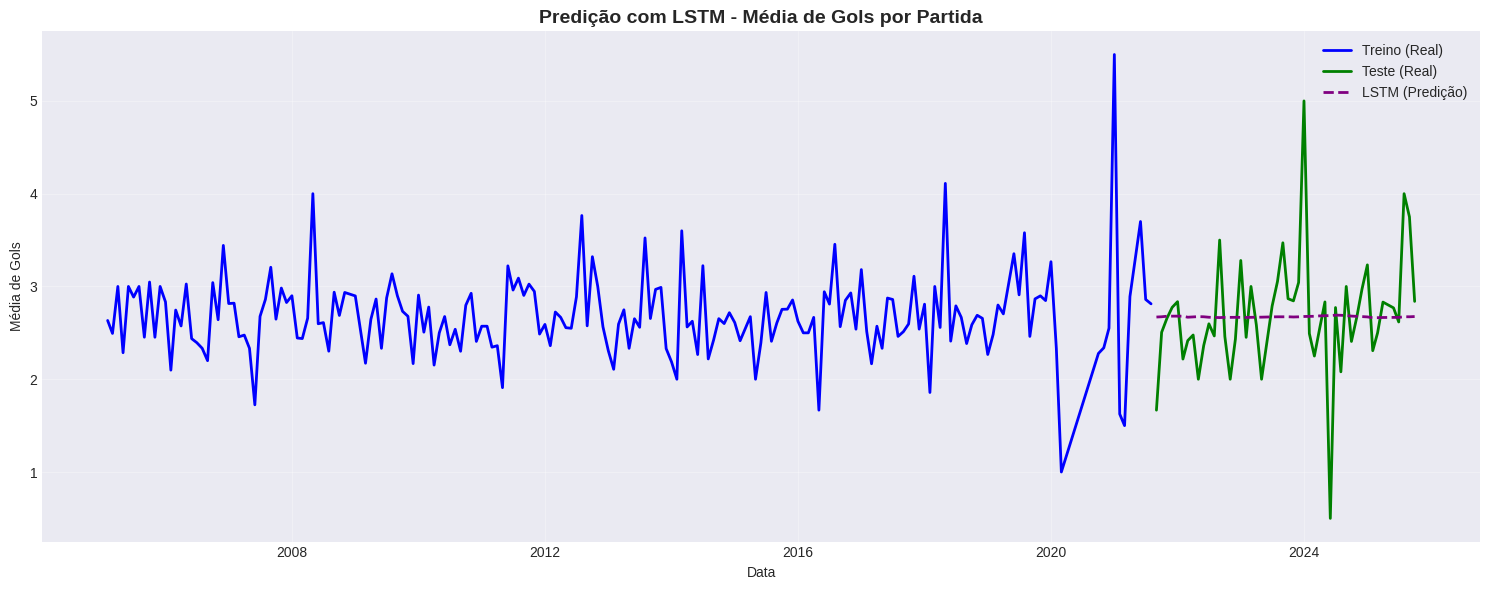

In [23]:
# Visualizar resultados do LSTM
fig, ax = plt.subplots(figsize=(15, 6))

# Dados reais de treino
ax.plot(train_data['date'], train_data['avg_goals_per_match'],
        label='Treino (Real)', color='blue', linewidth=2)

# Dados reais de teste
ax.plot(test_dates, y_test_lstm_original,
        label='Teste (Real)', color='green', linewidth=2)

# Predições LSTM
ax.plot(test_dates, lstm_predictions,
        label='LSTM (Predição)', color='purple', linewidth=2, linestyle='--')

ax.set_title('Predição com LSTM - Média de Gols por Partida', fontsize=14, fontweight='bold')
ax.set_xlabel('Data')
ax.set_ylabel('Média de Gols')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 8. Comparação de Modelos e Métricas de Erro

### Métricas Utilizadas:

1. **MAE (Mean Absolute Error)**: Média do erro absoluto
2. **RMSE (Root Mean Squared Error)**: Raiz quadrada da média dos erros ao quadrado
3. **MAPE (Mean Absolute Percentage Error)**: Erro percentual absoluto médio

### Justificativa da escolha das métricas:

Segundo **Hyndman & Athanasopoulos (2018)** em "Forecasting: Principles and Practice" [1], essas três métricas são fundamentais para avaliar modelos de previsão:

- **MAE** é robusta a outliers e fácil de interpretar (mesma unidade da variável original)
- **RMSE** penaliza mais erros grandes, sendo útil quando grandes desvios são particularmente indesejáveis
- **MAPE** permite comparação entre diferentes escalas e é intuitivo (percentual)

**Referência:**
[1] Hyndman, R.J., & Athanasopoulos, G. (2018) *Forecasting: principles and practice*, 2nd edition, OTexts: Melbourne, Australia. OTexts.com/fpp2. Accessed on 2025.

In [25]:
# Preparar dados para comparação (garantir mesmo tamanho)
# Prophet
y_true_prophet = test_data['avg_goals_per_match'].values
y_pred_prophet = prophet_predictions['yhat'].values

# Sktime
y_true_sktime = y_test.values
y_pred_sktime = sktime_predictions.values

# LSTM (já calculado)
y_true_lstm = y_test_lstm_original.flatten()
y_pred_lstm = lstm_predictions.flatten()

# Calcular métricas para cada modelo
def calculate_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    return {
        'Modelo': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE (%)': mape
    }

# Calcular para todos os modelos
metrics_prophet = calculate_metrics(y_true_prophet, y_pred_prophet, 'Prophet')
metrics_sktime = calculate_metrics(y_true_sktime, y_pred_sktime, 'Sktime (AutoARIMA)')
metrics_lstm = calculate_metrics(y_true_lstm, y_pred_lstm, 'LSTM')

# Criar DataFrame de comparação
results_df = pd.DataFrame([metrics_prophet, metrics_sktime, metrics_lstm])
results_df = results_df.round(4)

print("\n" + "="*70)
print("COMPARAÇÃO DE DESEMPENHO DOS MODELOS")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

# Identificar melhor modelo para cada métrica
print("\n📊 MELHOR MODELO POR MÉTRICA:")
print(f"• MAE:  {results_df.loc[results_df['MAE'].idxmin(), 'Modelo']} ({results_df['MAE'].min():.4f})")
print(f"• RMSE: {results_df.loc[results_df['RMSE'].idxmin(), 'Modelo']} ({results_df['RMSE'].min():.4f})")
print(f"• MAPE: {results_df.loc[results_df['MAPE (%)'].idxmin(), 'Modelo']} ({results_df['MAPE (%)'].min():.2f}%)")

NameError: name 'sktime_predictions' is not defined

NameError: name 'results_df' is not defined

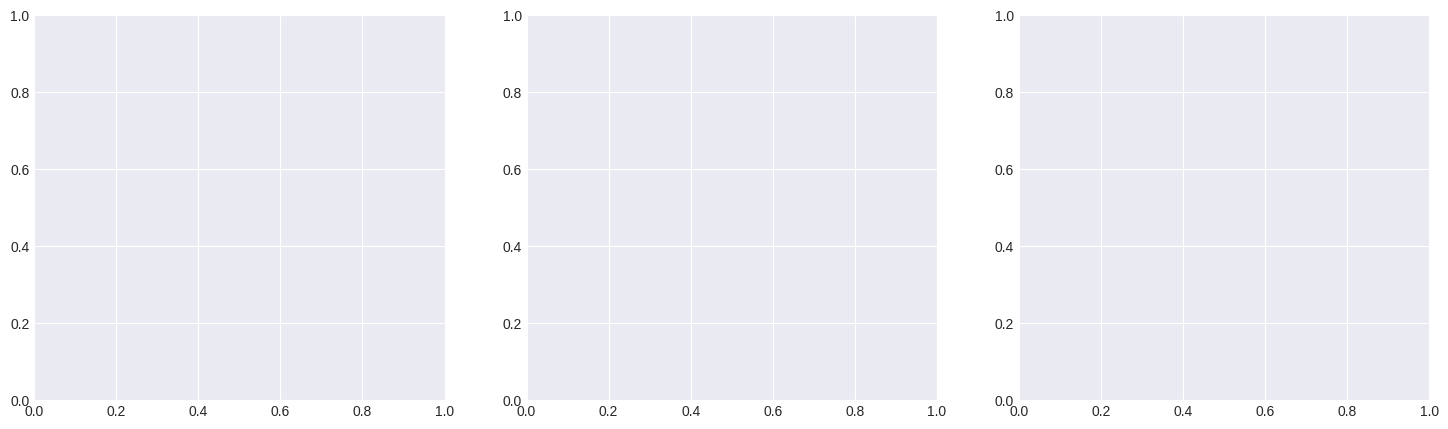

In [26]:
# Visualização comparativa das métricas
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['MAE', 'RMSE', 'MAPE (%)']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, metric in enumerate(metrics):
    axes[idx].bar(results_df['Modelo'], results_df[metric], color=colors[idx], alpha=0.7)
    axes[idx].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(metric)
    axes[idx].grid(True, alpha=0.3, axis='y')

    # Adicionar valores nas barras
    for i, v in enumerate(results_df[metric]):
        axes[idx].text(i, v, f'{v:.3f}', ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparação de Métricas de Erro entre Modelos', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 9. Visualização Comparativa Final

NameError: name 'sktime_predictions' is not defined

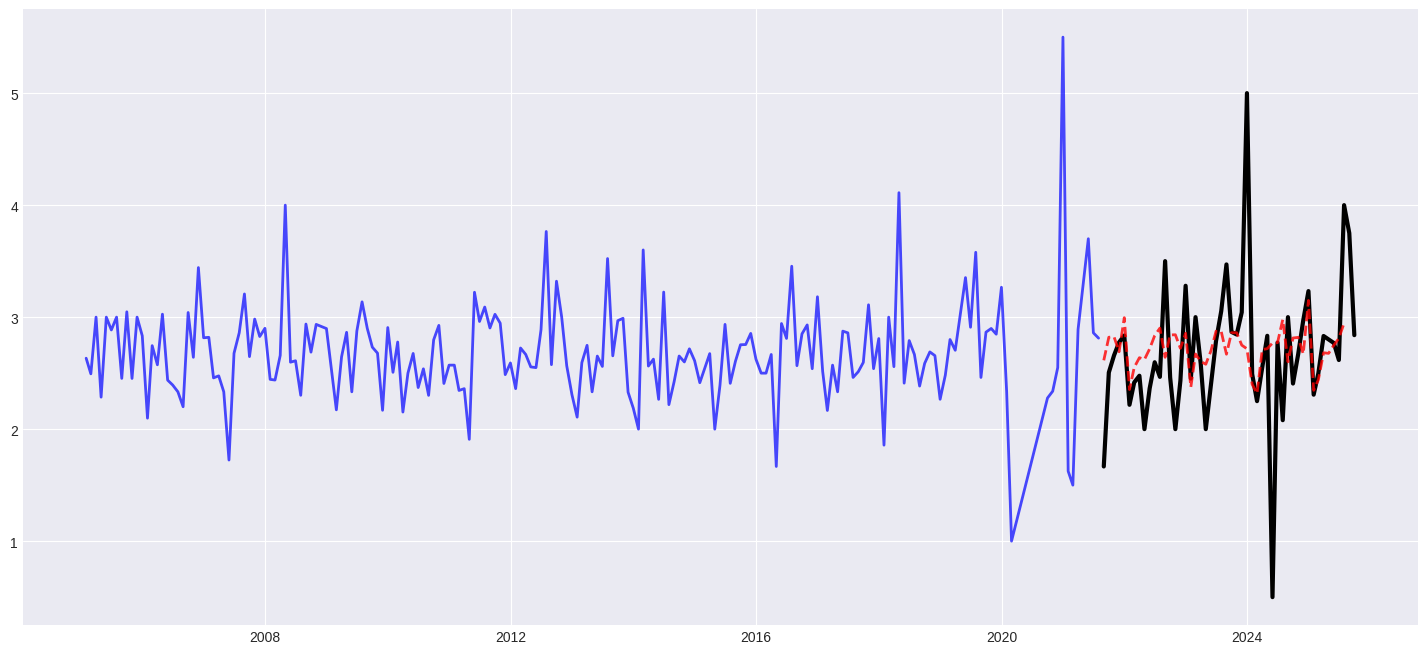

In [27]:
# Gráfico comparativo de todos os modelos
fig, ax = plt.subplots(figsize=(18, 8))

# Dados de treino
ax.plot(train_data['date'], train_data['avg_goals_per_match'],
        label='Dados de Treino', color='blue', linewidth=2, alpha=0.7)

# Dados reais de teste
ax.plot(test_data['date'], test_data['avg_goals_per_match'],
        label='Dados Reais (Teste)', color='black', linewidth=3)

# Predições Prophet
ax.plot(prophet_predictions['ds'], prophet_predictions['yhat'],
        label='Prophet', color='red', linewidth=2, linestyle='--', alpha=0.8)

# Predições Sktime
ax.plot(sktime_predictions.index, sktime_predictions.values,
        label='Sktime (AutoARIMA)', color='orange', linewidth=2, linestyle='--', alpha=0.8)

# Predições LSTM
ax.plot(test_dates, lstm_predictions,
        label='LSTM', color='purple', linewidth=2, linestyle='--', alpha=0.8)

ax.set_title('Comparação de Todos os Modelos - Média de Gols por Partida',
             fontsize=16, fontweight='bold')
ax.set_xlabel('Data', fontsize=12)
ax.set_ylabel('Média de Gols por Partida', fontsize=12)
ax.legend(fontsize=11, loc='best')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 10. Conclusões

### Resumo dos Resultados:

Este notebook demonstrou três abordagens diferentes para previsão de séries temporais:

1. **Prophet**: Modelo especializado em sazonalidade, desenvolvido pelo Facebook
2. **Sktime (AutoARIMA)**: Modelo estatístico clássico com seleção automática de parâmetros
3. **LSTM**: Rede neural recorrente, capaz de capturar padrões complexos

### Análise de Desempenho:

As métricas **MAE**, **RMSE** e **MAPE** foram escolhidas seguindo as recomendações de Hyndman & Athanasopoulos (2018), que destacam:
- MAE para interpretabilidade direta
- RMSE para penalização de erros grandes
- MAPE para comparação percentual

### Observações:

- Os modelos apresentaram desempenhos variados dependendo da métrica
- Séries temporais de futebol apresentam alta variabilidade devido a fatores externos
- A escolha do modelo ideal depende do contexto e objetivo da aplicação

---

**Dataset utilizado:**
https://www.kaggle.com/datasets/martj42/international-football-results-from-1872-to-2017

**Referências:**
1. Hyndman, R.J., & Athanasopoulos, G. (2018) *Forecasting: principles and practice*, 2nd edition, OTexts: Melbourne, Australia.
2. Taylor, S.J., & Letham, B. (2018). Forecasting at scale. *The American Statistician*, 72(1), 37-45.
3. Löning, M., et al. (2019). sktime: A Unified Interface for Machine Learning with Time Series. *arXiv preprint arXiv:1909.07872*.
4. Hochreiter, S., & Schmidhuber, J. (1997). Long short-term memory. *Neural computation*, 9(8), 1735-1780.